# Modelling Exploration Notebook
- Latent dirichlet allocation
- Text Classification into fixed categories
- Embed text and build clusers form the embedding space

# DeepAR

## Experiments

In [5]:
# !pip install sqlalchemy

In [1]:
from sqlalchemy import create_engine, Column, Integer, Float, String, ForeignKey, select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [3]:
Base = declarative_base()

class Forecast_Experiment(Base):
    __tablename__ = 'forecast_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model name', String(20))
    target = Column('target', String(100))
    past_rts_col = Column('past_rts_col', String(1000))
    epochs = Column('epochs', Integer)
    prediction_length = Column('prediction_length', Integer)
    num_layers = Column('num_layers', Integer)
    hidden_size = Column('hidden_size', Integer)
    MASE = Column('MASE', Float)
    MAPE = Column('MAPE', Float)
    RMSE = Column('RMSE', Float)
    wQL_10 = Column('wQL_01', Float)
    wQL_50 = Column('wQL_50', Float)
    wQL_90 = Column('wQL_90', Float)
    avg_wQL = Column('avg_wQL', Float)

/tmp/ipykernel_286/4201073751.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [4]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///./config/forecast_config.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

In [5]:
q1 = select(Forecast_Experiment)
q1_result = session.execute(q1) 
for s in q1_result.scalars():
    print(f"{s.model}: (e{s.epochs}, l{s.num_layers}, n{s.hidden_size}) \n   avg_wQL = {s.avg_wQL}\n   MASE = {s.MASE}")

torch_deepar: (e10, l2, n40) 
   avg_wQL = 0.15815992665967143
   MASE = 15.35258057965903
torch_deepar: (e200, l2, n40) 
   avg_wQL = 0.06275540445735626
   MASE = 6.097975824634244
torch_deepar: (e400, l2, n40) 
   avg_wQL = 0.05386742979053971
   MASE = 5.101011173035109
torch_deepar: (e200, l4, n40) 
   avg_wQL = 0.08651877718452138
   MASE = 8.039219094738732
torch_deepar: (e400, l4, n40) 
   avg_wQL = 0.072370957789048
   MASE = 6.602088947297926
torch_deepar: (e1000, l4, n40) 
   avg_wQL = 0.07117744262782484
   MASE = 6.556154368490975
torch_deepar: (e150, l4, n40) 
   avg_wQL = 0.11538632056465804
   MASE = 10.361089978606454
torch_deepar: (e150, l4, n40) 
   avg_wQL = 0.11614946049906973
   MASE = 10.268023090153697
torch_deepar: (e400, l2, n64) 
   avg_wQL = 0.06432785136177464
   MASE = 6.286316593529111


## DeepAR Modelling

In [11]:
# !pip install "gluonts[torch]"

In [6]:
# import deepar experiment method
from src.deepar_script import run_deepar_experiment
import matplotlib.pyplot as plt
import json

/opt/conda/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [7]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']

# Estimator specs
prediction_length=56
num_layers=2
hidden_size=64
context_length = 56 # implement in script

# Trainer specs
accelerator = "gpu"
devices = -1
max_epochs = 800

In [ ]:
forecasts, tss, agg_metrics = run_deepar_experiment(
    input_paths=input_paths,
    target_col=target_col,
    past_rts_col=past_rts_col,
    prediction_length=prediction_length,
    num_layers=num_layers,
    hidden_size=hidden_size,
    trainer_kwargs={
        "max_epochs": max_epochs, 
        "accelerator":accelerator, 
        "devices":devices
    },
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Par

Epoch 0: : 50it [00:06,  7.32it/s, v_num=22, train_loss=1.010]

Epoch 0, global step 50: 'train_loss' reached 1.00511 (best 1.00511), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_22/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:06,  7.43it/s, v_num=22, train_loss=0.823]

Epoch 1, global step 100: 'train_loss' reached 0.82301 (best 0.82301), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_22/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:06,  7.61it/s, v_num=22, train_loss=0.855]

Epoch 2, global step 150: 'train_loss' was not in top 1


Epoch 3: : 50it [00:06,  7.81it/s, v_num=22, train_loss=0.922]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: : 50it [00:06,  7.54it/s, v_num=22, train_loss=0.904]

Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: : 50it [00:06,  7.48it/s, v_num=22, train_loss=0.731]

Epoch 5, global step 300: 'train_loss' reached 0.73124 (best 0.73124), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_22/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: : 50it [00:06,  7.54it/s, v_num=22, train_loss=0.848]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: : 50it [00:06,  7.84it/s, v_num=22, train_loss=0.798]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: : 50it [00:06,  7.30it/s, v_num=22, train_loss=0.774]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: : 50it [00:06,  7.96it/s, v_num=22, train_loss=0.829]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: : 50it [00:06,  7.76it/s, v_num=22, train_loss=0.649]

Epoch 10, global step 550: 'train_loss' reached 0.64894 (best 0.64894), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_22/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: : 50it [00:06,  7.59it/s, v_num=22, train_loss=0.862]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: : 50it [00:06,  7.45it/s, v_num=22, train_loss=0.711]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: : 50it [00:06,  7.66it/s, v_num=22, train_loss=0.743]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: : 50it [00:06,  7.38it/s, v_num=22, train_loss=0.752]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: : 50it [00:06,  7.63it/s, v_num=22, train_loss=0.768]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: : 50it [00:06,  7.62it/s, v_num=22, train_loss=0.746]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: : 50it [00:06,  7.66it/s, v_num=22, train_loss=0.754]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: : 50it [00:06,  7.56it/s, v_num=22, train_loss=0.796]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: : 50it [00:06,  7.55it/s, v_num=22, train_loss=0.743]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: : 50it [00:06,  7.60it/s, v_num=22, train_loss=0.792]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: : 50it [00:06,  7.74it/s, v_num=22, train_loss=0.795]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: : 50it [00:06,  7.85it/s, v_num=22, train_loss=0.772]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: : 50it [00:06,  8.06it/s, v_num=22, train_loss=0.676]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: : 50it [00:06,  7.42it/s, v_num=22, train_loss=0.785]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: : 50it [00:06,  7.74it/s, v_num=22, train_loss=0.751]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: : 50it [00:06,  7.62it/s, v_num=22, train_loss=0.739]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: : 50it [00:06,  7.25it/s, v_num=22, train_loss=0.764]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: : 50it [00:06,  7.56it/s, v_num=22, train_loss=0.757]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: : 50it [00:06,  7.83it/s, v_num=22, train_loss=0.811]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: : 50it [00:06,  7.64it/s, v_num=22, train_loss=0.743]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: : 50it [00:06,  7.63it/s, v_num=22, train_loss=0.749]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: : 50it [00:06,  7.29it/s, v_num=22, train_loss=0.702]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: : 50it [00:07,  7.02it/s, v_num=22, train_loss=0.672]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: : 50it [00:06,  7.78it/s, v_num=22, train_loss=0.667]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: : 50it [00:06,  7.36it/s, v_num=22, train_loss=0.717]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: : 50it [00:07,  6.77it/s, v_num=22, train_loss=0.702]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: : 50it [00:06,  7.15it/s, v_num=22, train_loss=0.678]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: : 50it [00:07,  7.07it/s, v_num=22, train_loss=0.708]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: : 50it [00:07,  6.98it/s, v_num=22, train_loss=0.614]

Epoch 39, global step 2000: 'train_loss' reached 0.61372 (best 0.61372), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_22/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: : 50it [00:07,  7.07it/s, v_num=22, train_loss=0.622]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: : 50it [00:06,  7.47it/s, v_num=22, train_loss=0.704]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: : 50it [00:06,  7.53it/s, v_num=22, train_loss=0.678]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: : 50it [00:06,  7.45it/s, v_num=22, train_loss=0.691]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: : 50it [00:06,  7.19it/s, v_num=22, train_loss=0.609]

Epoch 44, global step 2250: 'train_loss' reached 0.60934 (best 0.60934), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_22/checkpoints/epoch=44-step=2250.ckpt' as top 1


Epoch 45: : 50it [00:06,  7.52it/s, v_num=22, train_loss=0.664]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: : 50it [00:06,  7.53it/s, v_num=22, train_loss=0.620]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: : 50it [00:06,  7.78it/s, v_num=22, train_loss=0.613]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: : 50it [00:06,  7.56it/s, v_num=22, train_loss=0.725]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: : 50it [00:06,  7.35it/s, v_num=22, train_loss=0.586]

Epoch 49, global step 2500: 'train_loss' reached 0.58602 (best 0.58602), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_22/checkpoints/epoch=49-step=2500.ckpt' as top 1


Epoch 50: : 50it [00:06,  7.62it/s, v_num=22, train_loss=0.795]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: : 50it [00:06,  7.34it/s, v_num=22, train_loss=0.675]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: : 50it [00:06,  7.79it/s, v_num=22, train_loss=0.668]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: : 50it [00:06,  7.42it/s, v_num=22, train_loss=0.669]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: : 50it [00:06,  7.70it/s, v_num=22, train_loss=0.689]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: : 50it [00:06,  7.63it/s, v_num=22, train_loss=0.703]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: : 50it [00:06,  7.55it/s, v_num=22, train_loss=0.664]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: : 50it [00:06,  7.61it/s, v_num=22, train_loss=0.623]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: : 50it [00:06,  7.53it/s, v_num=22, train_loss=0.648]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: : 50it [00:06,  7.66it/s, v_num=22, train_loss=0.742]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: : 50it [00:06,  7.28it/s, v_num=22, train_loss=0.655]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: : 50it [00:06,  7.58it/s, v_num=22, train_loss=0.664]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: : 50it [00:06,  7.55it/s, v_num=22, train_loss=0.702]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: : 50it [00:06,  7.57it/s, v_num=22, train_loss=0.680]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: : 50it [00:06,  7.62it/s, v_num=22, train_loss=0.735]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: : 50it [00:06,  7.70it/s, v_num=22, train_loss=0.683]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: : 50it [00:06,  7.94it/s, v_num=22, train_loss=0.639]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: : 50it [00:06,  7.69it/s, v_num=22, train_loss=0.663]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: : 50it [00:06,  7.44it/s, v_num=22, train_loss=0.616]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: : 50it [00:07,  7.11it/s, v_num=22, train_loss=0.716]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: : 50it [00:06,  7.47it/s, v_num=22, train_loss=0.655]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: : 50it [00:07,  7.13it/s, v_num=22, train_loss=0.635]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: : 50it [00:06,  7.89it/s, v_num=22, train_loss=0.700]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: : 50it [00:06,  8.05it/s, v_num=22, train_loss=0.658]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: : 50it [00:06,  7.64it/s, v_num=22, train_loss=0.597]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: : 50it [00:06,  7.59it/s, v_num=22, train_loss=0.635]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: : 50it [00:06,  7.84it/s, v_num=22, train_loss=0.730]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: : 50it [00:06,  7.45it/s, v_num=22, train_loss=0.669]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: : 50it [00:06,  8.01it/s, v_num=22, train_loss=0.711]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: : 50it [00:06,  7.70it/s, v_num=22, train_loss=0.541]

Epoch 79, global step 4000: 'train_loss' reached 0.54096 (best 0.54096), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_22/checkpoints/epoch=79-step=4000.ckpt' as top 1


Epoch 80: : 50it [00:06,  7.89it/s, v_num=22, train_loss=0.690]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: : 50it [00:06,  7.34it/s, v_num=22, train_loss=0.719]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: : 50it [00:06,  7.67it/s, v_num=22, train_loss=0.673]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: : 50it [00:06,  7.32it/s, v_num=22, train_loss=0.670]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: : 50it [00:06,  7.75it/s, v_num=22, train_loss=0.657]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: : 50it [00:06,  7.63it/s, v_num=22, train_loss=0.661]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: : 50it [00:06,  7.84it/s, v_num=22, train_loss=0.699]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: : 50it [00:06,  7.77it/s, v_num=22, train_loss=0.665]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: : 50it [00:06,  7.52it/s, v_num=22, train_loss=0.609]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: : 50it [00:06,  7.50it/s, v_num=22, train_loss=0.703]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: : 50it [00:06,  7.71it/s, v_num=22, train_loss=0.602]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: : 50it [00:06,  7.77it/s, v_num=22, train_loss=0.697]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: : 50it [00:06,  7.83it/s, v_num=22, train_loss=0.585]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: : 50it [00:06,  7.47it/s, v_num=22, train_loss=0.623]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: : 50it [00:06,  7.81it/s, v_num=22, train_loss=0.663]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: : 50it [00:06,  7.56it/s, v_num=22, train_loss=0.664]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: : 50it [00:06,  7.91it/s, v_num=22, train_loss=0.497]

Epoch 96, global step 4850: 'train_loss' reached 0.49684 (best 0.49684), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_22/checkpoints/epoch=96-step=4850.ckpt' as top 1


Epoch 97: : 50it [00:06,  7.45it/s, v_num=22, train_loss=0.621]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: : 50it [00:06,  7.71it/s, v_num=22, train_loss=0.610]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: : 50it [00:06,  7.70it/s, v_num=22, train_loss=0.658]

Epoch 99, global step 5000: 'train_loss' was not in top 1


Epoch 100: : 50it [00:06,  7.79it/s, v_num=22, train_loss=0.667]

Epoch 100, global step 5050: 'train_loss' was not in top 1


Epoch 101: : 50it [00:06,  7.40it/s, v_num=22, train_loss=0.629]

Epoch 101, global step 5100: 'train_loss' was not in top 1


Epoch 102: : 50it [00:06,  7.84it/s, v_num=22, train_loss=0.603]

Epoch 102, global step 5150: 'train_loss' was not in top 1


Epoch 103: : 50it [00:06,  7.39it/s, v_num=22, train_loss=0.671]

Epoch 103, global step 5200: 'train_loss' was not in top 1


Epoch 104: : 50it [00:06,  7.73it/s, v_num=22, train_loss=0.581]

Epoch 104, global step 5250: 'train_loss' was not in top 1


Epoch 105: : 50it [00:06,  7.41it/s, v_num=22, train_loss=0.638]

Epoch 105, global step 5300: 'train_loss' was not in top 1


Epoch 106: : 50it [00:06,  7.68it/s, v_num=22, train_loss=0.647]

Epoch 106, global step 5350: 'train_loss' was not in top 1


Epoch 107: : 50it [00:06,  7.36it/s, v_num=22, train_loss=0.594]

Epoch 107, global step 5400: 'train_loss' was not in top 1


Epoch 108: : 50it [00:06,  7.36it/s, v_num=22, train_loss=0.680]

Epoch 108, global step 5450: 'train_loss' was not in top 1


Epoch 109: : 50it [00:06,  7.85it/s, v_num=22, train_loss=0.657]

Epoch 109, global step 5500: 'train_loss' was not in top 1


Epoch 110: : 50it [00:06,  7.63it/s, v_num=22, train_loss=0.680]

Epoch 110, global step 5550: 'train_loss' was not in top 1


Epoch 111: : 50it [00:06,  7.52it/s, v_num=22, train_loss=0.643]

Epoch 111, global step 5600: 'train_loss' was not in top 1


Epoch 112: : 50it [00:06,  7.76it/s, v_num=22, train_loss=0.671]

Epoch 112, global step 5650: 'train_loss' was not in top 1


Epoch 113: : 50it [00:06,  7.77it/s, v_num=22, train_loss=0.670]

Epoch 113, global step 5700: 'train_loss' was not in top 1


Epoch 114: : 50it [00:06,  7.65it/s, v_num=22, train_loss=0.619]

Epoch 114, global step 5750: 'train_loss' was not in top 1


Epoch 115: : 50it [00:06,  7.53it/s, v_num=22, train_loss=0.635]

Epoch 115, global step 5800: 'train_loss' was not in top 1


Epoch 116: : 50it [00:06,  7.84it/s, v_num=22, train_loss=0.631]

Epoch 116, global step 5850: 'train_loss' was not in top 1


Epoch 117: : 50it [00:06,  7.65it/s, v_num=22, train_loss=0.648]

Epoch 117, global step 5900: 'train_loss' was not in top 1


Epoch 118: : 50it [00:06,  7.48it/s, v_num=22, train_loss=0.595]

Epoch 118, global step 5950: 'train_loss' was not in top 1


Epoch 119: : 50it [00:06,  7.69it/s, v_num=22, train_loss=0.699]

Epoch 119, global step 6000: 'train_loss' was not in top 1


Epoch 120: : 50it [00:06,  7.73it/s, v_num=22, train_loss=0.624]

Epoch 120, global step 6050: 'train_loss' was not in top 1


Epoch 121: : 50it [00:06,  7.50it/s, v_num=22, train_loss=0.639]

Epoch 121, global step 6100: 'train_loss' was not in top 1


Epoch 122: : 50it [00:06,  7.50it/s, v_num=22, train_loss=0.636]

Epoch 122, global step 6150: 'train_loss' was not in top 1


Epoch 123: : 50it [00:06,  7.90it/s, v_num=22, train_loss=0.630]

Epoch 123, global step 6200: 'train_loss' was not in top 1


Epoch 124: : 50it [00:06,  7.95it/s, v_num=22, train_loss=0.610]

Epoch 124, global step 6250: 'train_loss' was not in top 1


Epoch 125: : 50it [00:06,  7.63it/s, v_num=22, train_loss=0.742]

Epoch 125, global step 6300: 'train_loss' was not in top 1


Epoch 126: : 50it [00:06,  7.85it/s, v_num=22, train_loss=0.697]

Epoch 126, global step 6350: 'train_loss' was not in top 1


Epoch 127: : 50it [00:06,  7.77it/s, v_num=22, train_loss=0.618]

Epoch 127, global step 6400: 'train_loss' was not in top 1


Epoch 128: : 50it [00:06,  7.67it/s, v_num=22, train_loss=0.637]

Epoch 128, global step 6450: 'train_loss' was not in top 1


Epoch 129: : 50it [00:06,  7.63it/s, v_num=22, train_loss=0.764]

Epoch 129, global step 6500: 'train_loss' was not in top 1


Epoch 130: : 50it [00:06,  7.70it/s, v_num=22, train_loss=0.690]

Epoch 130, global step 6550: 'train_loss' was not in top 1


Epoch 131: : 50it [00:06,  7.68it/s, v_num=22, train_loss=0.621]

Epoch 131, global step 6600: 'train_loss' was not in top 1


Epoch 132: : 50it [00:06,  7.86it/s, v_num=22, train_loss=0.685]

Epoch 132, global step 6650: 'train_loss' was not in top 1


Epoch 133: : 50it [00:06,  7.64it/s, v_num=22, train_loss=0.637]

Epoch 133, global step 6700: 'train_loss' was not in top 1


Epoch 134: : 50it [00:06,  7.69it/s, v_num=22, train_loss=0.642]

Epoch 134, global step 6750: 'train_loss' was not in top 1


Epoch 135: : 50it [00:06,  7.79it/s, v_num=22, train_loss=0.649]

Epoch 135, global step 6800: 'train_loss' was not in top 1


Epoch 136: : 50it [00:06,  7.56it/s, v_num=22, train_loss=0.697]

Epoch 136, global step 6850: 'train_loss' was not in top 1


Epoch 137: : 50it [00:06,  7.58it/s, v_num=22, train_loss=0.601]

Epoch 137, global step 6900: 'train_loss' was not in top 1


Epoch 138: : 50it [00:06,  7.72it/s, v_num=22, train_loss=0.669]

Epoch 138, global step 6950: 'train_loss' was not in top 1


Epoch 139: : 50it [00:06,  7.80it/s, v_num=22, train_loss=0.603]

Epoch 139, global step 7000: 'train_loss' was not in top 1


Epoch 140: : 50it [00:06,  7.90it/s, v_num=22, train_loss=0.689]

Epoch 140, global step 7050: 'train_loss' was not in top 1


Epoch 141: : 50it [00:06,  8.18it/s, v_num=22, train_loss=0.663]

Epoch 141, global step 7100: 'train_loss' was not in top 1


Epoch 142: : 50it [00:06,  7.56it/s, v_num=22, train_loss=0.681]

Epoch 142, global step 7150: 'train_loss' was not in top 1


Epoch 143: : 50it [00:06,  7.89it/s, v_num=22, train_loss=0.643]

Epoch 143, global step 7200: 'train_loss' was not in top 1


Epoch 144: : 50it [00:06,  7.59it/s, v_num=22, train_loss=0.608]

Epoch 144, global step 7250: 'train_loss' was not in top 1


Epoch 145: : 50it [00:06,  7.35it/s, v_num=22, train_loss=0.573]

Epoch 145, global step 7300: 'train_loss' was not in top 1


Epoch 146: : 50it [00:06,  7.71it/s, v_num=22, train_loss=0.660]

Epoch 146, global step 7350: 'train_loss' was not in top 1


Epoch 147: : 50it [00:06,  7.72it/s, v_num=22, train_loss=0.625]

Epoch 147, global step 7400: 'train_loss' was not in top 1


Epoch 148: : 50it [00:06,  7.29it/s, v_num=22, train_loss=0.580]

Epoch 148, global step 7450: 'train_loss' was not in top 1


Epoch 149: : 45it [00:06,  7.08it/s, v_num=22, train_loss=0.580]

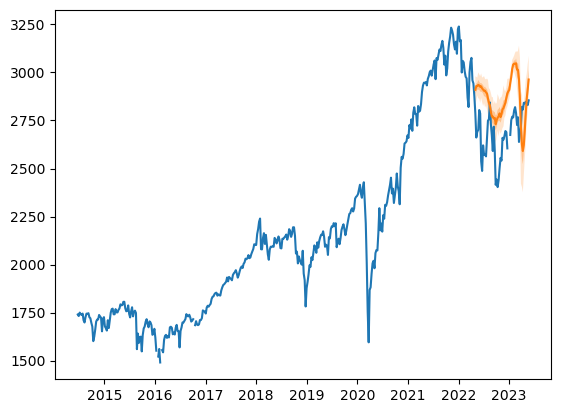

In [19]:
for ts, forecast in zip(tss, forecasts):
    plt.plot(ts.to_timestamp())
    forecast.plot()

In [20]:
experiment_config = Forecast_Experiment(
    model = 'torch_deepar',
    target = target_col,
    past_rts_col = str(past_rts_col),
    epochs = max_epochs,
    prediction_length = prediction_length,
    num_layers = num_layers,
    hidden_size = hidden_size,
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit()

# NLP

## Experiments

In [2]:
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [3]:
Base = declarative_base()

class Experiment(Base):
    __tablename__ = 'lda_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model_path', String(100))
    dataset = Column('dataset_path', String(100))
    num_topics = Column('num_topics', Integer)
    epochs = Column('passes', Integer)


In [4]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///config/experiment_config.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### Query Experiments

In [5]:
q1 = select(Experiment)
q1_result = session.execute(q1) 
for s in q1_result.scalars():
    print(f"{s.model}")

lda_model_topics_5_passes_10
lda_model_topics_10_passes_10
lda_model_topics_50_passes_10
lda_model_topics_100_passes_10
lda_model_topics_500_passes_10
lda_model_topics_1000_passes_10
lda_model_topics_10_passes_20
lda_model_topics_50_passes_20
lda_model_topics_100_passes_20
lda_model_topics_500_passes_20
lda_model_topics_1000_passes_20
lda_model_topics_10_passes_50
lda_model_topics_50_passes_50
lda_model_topics_100_passes_50
lda_model_topics_500_passes_50
lda_model_topics_1000_passes_50
lda_model_topics_1000_passes_50_on_title_lemmatized


## [LDA Modelling](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925)


In [8]:
# import lda experiment method
from src.lda_script import run_lda_experiment

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Create Single Experiment

In [5]:
num_topics = 1000
num_passes = 50
dataset_name = 'cnbc_news_dataset_processed'
data_input_path = f'../data_engineering/nlp_data/{dataset_name}.csv'
data_output_path = './output_data/'
# input_column='short_description_lemmatized'
input_column='title_lemmatized'

In [6]:

# Start Experiment
run_lda_experiment(
    num_topics=num_topics,
    num_passes=num_passes,
    data_input_path=data_input_path,
    data_output_path=data_output_path,
    dataset_name=dataset_name,
    input_column=input_column
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/gensim/models/ldamodel.py:850: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [11]:
model_name = f'lda_model_topics_{num_topics}_passes_{num_passes}_on_{input_column}'
experiment_config = Experiment(
    model = model_name, 
    dataset = dataset_name, 
    num_topics=num_topics, 
    epochs=num_passes
)
session.add(experiment_config)
session.commit()

### Create Set of Experiments

In [6]:
# num_topics = 1000
# num_passes = 50
dataset_name = 'cnbc_news_dataset_processed'
data_input_path = f'../data_engineering/nlp_data/{dataset_name}.csv'
data_output_path = './output_data/'
# input_column='short_description_lemmatized'
input_column='title_lemmatized'

In [9]:
for num_t in [5,10,50,100,500,1000]:
    for num_p in [5,10,50,100,500,1000]:
        # Start Experiment
        run_lda_experiment(
            num_topics=num_t,
            num_passes=num_p,
            data_input_path=data_input_path,
            data_output_path=data_output_path,
            dataset_name=dataset_name,
            input_column=input_column
        )   
        # Save model and config
        model_name = f'lda_model_topics_{num_t}_passes_{num_p}_on_{input_column}'
        experiment_config = Experiment(
            model = model_name, 
            dataset = dataset_name, 
            num_topics=num_t, 
            epochs=num_p
        )
        session.add(experiment_config)
        session.commit()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


NameError: name 'num_topics' is not defined